In [8]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
print(cv2.__version__)

from collections import defaultdict
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer.pitch import Pitch
from matplotlib import animation
from pykalman import KalmanFilter
import time
from scipy.ndimage.filters import gaussian_filter1d
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from scipy.signal import savgol_filter
from ast import literal_eval as leval
import matplotlib.image as mpimg

4.5.5


In [2]:
# Read Video
video = cv2.VideoCapture('italy.mp4')

In [3]:
#Extract Frames
count = 0
while True:
    success, image = video.read()
    if not success:
        break
    cv2.imwrite(f'frames/frame{count}.jpg', image)
    count += 1

print(f'{count} images extracted to frames')

750 images extracted to frames


In [4]:
#Crop frames to make smaller video

folder = 'frames'
img_array = []

for i in range(360,459):
    filename = os.path.join(folder, 'frame'+str(i)+'.jpg')
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('croppeditaly.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])

out.release()

In [63]:
TrDict = {'csrt':cv2.legacy.TrackerCSRT_create, "kcf": cv2.legacy.TrackerKCF_create, "mosse": cv2.legacy.TrackerMOSSE_create}

In [64]:
trackers = cv2.legacy.MultiTracker_create()

In [65]:
v = cv2.VideoCapture('croppeditaly.mp4',0)

In [66]:
length = int(v.get(cv2.CAP_PROP_FRAME_COUNT))
length

99

In [67]:
ret, frame = v.read()

In [68]:
# set trackers
k = 2
for i in range(k):
    height, width, layers = frame.shape
    new_h = int(height/2)
    new_w = int(width/2)
    resize = cv2.resize(frame, (new_w, new_h))
    cv2.imshow('Frame', resize)
    bbi = cv2.selectROI('Frame', resize)
    tracker_i = TrDict['csrt']()
    trackers.add(tracker_i, resize, bbi)

In [69]:
# trackers
# tracker_i

In [70]:
allcoords =[]

for i in range(length):
    coordlist = []
    ret, frame = v.read()
    if type(frame) != type(None):
        height, width, layers = frame.shape
        new_h = int(height/2)
        new_w = int(width/2)
        resize = cv2.resize(frame, (new_w, new_h))
    else:
        break

    if not ret:
        break

    success, boxes = trackers.update(resize)

    for box in boxes :
        (x,y,w,h) = [int(a) for a in box]
        cv2.rectangle(resize, (x,y), (x+w, y+h), (100,255,0),2)
        coordlist.append((x+w/2, y+h))
    
    allcoords.append(coordlist)
    cv2.imshow('Frame', resize)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q'):
        break

v.release()
cv2.destroyAllWindows()

In [71]:
import pandas as pd

# columns = ['tl','bl','tr','br']

# columns = ['h1','h2']

columns = ['a1','a2']
df = pd.DataFrame(data = allcoords, columns=columns)


In [72]:
df.to_csv('pos/a12.csv')

## ============================================================================

In [162]:
df = pd.read_csv('pos/tracking_1.csv')
pts2 = np.int32([[120,30],[120,50],[114,50],[114,30]])

In [163]:
for i in range(len(df)):
    n1 = [leval(str(df.iloc[i,1]))[0], str(leval(df.iloc[i,1]))[1]]
    n2 = [leval(str(df.iloc[i,2]))[0], str(leval(df.iloc[i,2]))[1]]
    n3 = [leval(str(df.iloc[i,3]))[0], str(leval(df.iloc[i,3]))[1]]
    n4 = [leval(str(df.iloc[i,4]))[0], str(leval(df.iloc[i,4]))[1]]
    refPt = [n1,n2,n3,n4]
    pts1 = np.float32(refPt)
    matrix, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)

    for j in range(1,len(df.columns.tolist())):
        xold = leval(df.iloc[i,j])[0]
        yold = leval(df.iloc[i,j])[1]
        xnew = (matrix[0][0]*xold + matrix[0][1]*yold + matrix[0][2])/(matrix[2][0]*xold + matrix[2][1]*yold + matrix[2][2])
        ynew = (matrix[1][0]*xold + matrix[1][1]*yold + matrix[1][2])/(matrix[2][0]*xold + matrix[2][1]*yold + matrix[2][2])

        df.iat[i,j] = (round(xnew,2), round(ynew,2))

headers = df.columns.tolist()

homeindex = [headers[i] for i in range(1,len(headers)) if 'h' in headers[i]]
awayindex = [headers[i] for i in range(1, len(headers)) if 'a' in headers[i]]

In [164]:
df.head()

,frame,tl,tr,br,bl,h1,h2,a1,a2
0,1,"(317.74, 40.93)","(311.36, 40.93)","(312.05, 40.89)","(317.1, 40.89)","(310.98, 40.81)","(314.29, 40.8)","(313.1, 40.81)","(311.88, 40.83)"
1,2,"(290.97, 39.5)","(285.45, 39.5)","(285.96, 39.46)","(290.34, 39.46)","(284.83, 39.38)","(287.66, 39.37)","(286.65, 39.37)","(285.65, 39.39)"
2,3,"(290.97, 39.5)","(285.45, 39.5)","(285.96, 39.46)","(290.34, 39.46)","(284.85, 39.38)","(287.67, 39.37)","(286.64, 39.37)","(285.63, 39.39)"
3,4,"(290.97, 39.5)","(285.45, 39.5)","(285.96, 39.46)","(290.34, 39.46)","(284.83, 39.38)","(287.67, 39.37)","(286.64, 39.37)","(285.61, 39.39)"
4,5,"(317.74, 40.93)","(311.36, 40.93)","(312.05, 40.89)","(317.1, 40.89)","(311.0, 40.81)","(314.29, 40.8)","(313.09, 40.81)","(311.85, 40.83)"


In [165]:
homeindex
awayindex

['a1', 'a2']

In [166]:
# [i for i in range(1,len(headers))]

In [167]:
def smootheout(x,y,sigma):
    xsmooth = gaussian_filter1d(x,sigma)
    ysmooth = gaussian_filter1d(y,sigma)
    return xsmooth, ysmooth

def savitzkysmoothing(x,y,sigma):
    xsmooth = savgol_filter(x,sigma,1)
    ysmooth = savgol_filter(y,sigma,1)
    return xsmooth, ysmooth

def smootheandfill(indexlist, sigma):
    Df = pd.DataFrame()
    Df['Frame'] = [i for i in range(len(df))]
    for i in range(len(indexlist)):
        Df['x' + str(i+1)], Df['y' + str(i+1)] = zip(*df[indexlist[i]])
        Df['x' + str(i+1)], Df['y' + str(i+1)] = smootheout(Df['x' + str(i+1)], Df['y' + str(i+1)], sigma)
    return Df

hdf = smootheandfill(homeindex, 3)
adf = smootheandfill(awayindex, 5)

In [168]:
# hdf.columns[:1]
hdf = hdf.div(10)
# hdf

In [169]:
adf = adf.div(10)

In [170]:
def to_long_form(df):
    df = pd.melt(df, id_vars = df.columns[:1], value_vars = df.columns[1:], var_name = 'player') #, value_name = 'Coordinates')
    if len(df) !=  0:
        df.loc[df.player.str.contains('x'), 'coordinate'] = 'x'
        df.loc[df.player.str.contains('y'), 'coordinate'] = 'y'

        df = df.dropna(axis=0, how='any')
        df['player'] = df.player.str[1:]

        df = (df.set_index(['Frame', 'player', 'coordinate'])['value']
            .unstack()
            .reset_index()
            .rename_axis(None, axis=1))
        return df
    else:
        return 'No data'


df_home = to_long_form(hdf)
df_away= to_long_form(adf)

In [171]:
# df_home
# df_away

# a = [i for i in range(1,len(hdf))]
# len(a)

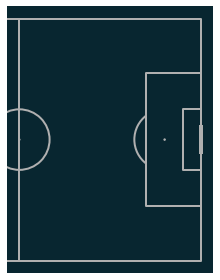

In [172]:
pitch = Pitch(pitch_type='statsbomb', figsize = (4,8), goal_type='line', half = True, orientation='horizontal', pitch_color='#082630')
fig, ax = pitch.draw()
marker_kwargs = {'marker':'o', 'linestyle': 'None'}
marker_kwargs2 = {'marker':'o', 'linestyle': 'None'}

home, = ax.plot([],[], ms = 10 ,zorder = 3 ,**marker_kwargs, label='Home')  # ,zorder = 3
away, = ax.plot([],[], ms = 10 ,zorder = 2 , **marker_kwargs2, label='Away') # ,zorder = 1

def animate(i):
    frame = i
    home.set_data(df_home.loc[df_home.Frame == frame, 'x'], df_home.loc[df_home.Frame == frame, 'y'])
    away.set_data(df_away.loc[df_away.Frame == frame, 'x'], df_away.loc[df_away.Frame == frame, 'y'])

    return home,away

anim = animation.FuncAnimation(fig, animate, frames=len(hdf), interval=100 , blit = True)
plt.show()


In [173]:
home

In [174]:
df_home.loc[df_home.Frame == frame, 'x'], df_home.loc[df_home.Frame == frame, 'y']

(Series([], Name: x, dtype: float64), Series([], Name: y, dtype: float64))

In [175]:
anim.save('anim/italytracking_2.mp4', dpi=300, fps=30, extra_args=['-vcodec', 'libx264'])

In [152]:
hdf.to_csv('pos/home.csv')
adf.to_csv('pos/away.csv')